In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import os
import scipy as sp
import scipy.optimize as opt
import matplotlib.style as style

mplstyle_path = os.path.join(os.getcwd(), 'prx.mplstyle')
style.use(mplstyle_path)


save_plot_path = os.getcwd()
print("Will save all plots to", save_plot_path)

Will save all plots to s:\Connie\experiments\qram_tprocv1_expts\data_plot


# Fitting functions

In [3]:
def fit(x, p, B, A):
    return B*p**x + A


def rb_decay_l1_l2(depth, p1, a0, b0, c0, p2):
    """
    Fit decay of g state in subspace when accounting for leakage and seepage
    p1 should be fixed by fitting using the regular rb decay
    """
    return a0 + b0 * p1**depth + c0 * p2**depth


def rb_fidelity_l1_l2(d, p2, l1, p2_err=None, l1_err=None):  # d = dim of subspace
    fid = (1 / d) * ((d - 1) * p2 + 1 - l1)
    if p2_err is not None and l1_err is not None:
        fid_err_sqrd = ((1 / d) * (d - 1) * p2_err) ** 2 + ((1 / d) * l1_err) ** 2
        fid_err = np.sqrt(fid_err_sqrd)
        return fid, fid_err
    return fid


def fitrb_l1_l2(xdata, ydata, p1, offset=0.5, fitparams=None, sigma=None):
    if fitparams is None:
        fitparams = [None] * 4
    else:
        fitparams = np.copy(fitparams)
    if fitparams[0] is None:
        fitparams[0] = 0.5 * offset  # a0
    if fitparams[1] is None:
        fitparams[1] = 0.5  # b0
    if fitparams[2] is None:
        fitparams[2] = 0.5  # c0
    if fitparams[3] is None:
        fitparams[3] = 0.9  # p2
    bounds = ([0, 0, 0, 0], [min((1.2 * offset, 1)), 1, 1, 1])
    for i, param in enumerate(fitparams):
        if not (bounds[0][i] < param < bounds[1][i]):
            fitparams[i] = np.mean((bounds[0][i], bounds[1][i]))
            print(
                f"Attempted to init fitparam {i} to {param}, which is out of bounds {bounds[0][i]} to {bounds[1][i]}. Instead init to {fitparams[i]}"
            )
    pOpt = fitparams
    pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
    try:
        pOpt, pCov = sp.optimize.curve_fit(
            lambda depth, a0, b0, c0, p2: rb_decay_l1_l2(depth, p1, a0, b0, c0, p2),
            xdata,
            ydata,
            sigma=sigma,  # use the standard error std/sqrt(n)
            p0=fitparams,
            bounds=bounds,
        )
    except (RuntimeError, ValueError) as e:
        print("Warning: fit failed with error:", e)
    return pOpt, pCov

# State ordering

In [43]:
state_subspace_12 = ['geg', 'ggf']
state_subspace_13 = ['eeg', 'egf']

state_leak = ['ggg', 'gge', 'gee', 'gef', 'egg', 'ege','eee', 'eef']

switch_e = ['eeg', 'egf', 'egg', 'ege','eee', 'eef']
switch_g = ['geg', 'ggf', 'ggg', 'gge', 'gee', 'gef']

calib_order = ['ggg', 'gge', 'ggf', 'geg', 'gee', 'gef', 'egg', 'ege', 'egf', 'eeg', 'eee', 'eef']
state_name_str = calib_order

state_erasure = [] # no states are considered erasure states

# Main text RB

## Import RB data used in main text

In [5]:
file_name_q1q2 = '00004_rb_EgGf_qubit21.h5'
file_name_q1q2_bis = '00005_rb_EgGf_qubit21.h5'
file_name_q1q2_irb = '00006_rb_EgGf_qubit21.h5'
file_name_q1q2_irb_bis = '00007_rb_EgGf_qubit21.h5'
file_name_q1q3 = '00014_rb_EgGf_qubit31.h5'
file_name_q1q3_bis = '00015_rb_EgGf_qubit31.h5'
file_name_q1q3_irb = '00016_rb_EgGf_qubit31.h5'
file_name_q1q3_irb_bis = '00017_rb_EgGf_qubit31.h5'

save_path_name = os.path.join(os.getcwd(), 'RB')


datafile_13 =os.path.join(save_path_name, file_name_q1q3[:5] + '_' + file_name_q1q3_bis[:5] + '_merged_rb_EgGf_qubit31.npz')
datafile_13_irb = os.path.join(save_path_name, file_name_q1q3_irb[:5] + '_' + file_name_q1q3_irb_bis[:5] + '_merged_rb_EgGf_qubit31.npz')
datafile_12 = os.path.join(save_path_name, file_name_q1q2[:5] + '_' + file_name_q1q2_bis[:5] + '_merged_rb_EgGf_qubit21.npz')
datafile_12_irb = os.path.join(save_path_name, file_name_q1q2_irb[:5] + '_' + file_name_q1q2_irb_bis[:5] + '_merged_rb_EgGf_qubit21.npz')

data_13 = np.load(datafile_13 )
data_13_x = np.load(datafile_13_irb)
data_12 = np.load(datafile_12 )
data_12_x = np.load(datafile_12_irb)

## Data processing for RB

### Input-output 2

#### Compute error bars for input-output2

In [6]:
xpts = data_13['xpts']
pop_13 = data_13['pop']

In [7]:
# reload the data
n = len(np.asarray(xpts)[0])

pop_dict_13 = {}
pop_dict_13['avg'] = {}
pop_dict_13['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13 should be < 1
    
    _pop = pop_13[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))
    pop_dict_13['avg'][state] = _pop_post_avg
    pop_dict_13['err'][state] = _pop_post_err

    x_rb_13 = np.unique(xpts)

#### Define the subspace for the same swap

In [8]:
# define the subspace population and its error
popln_subspace_avg_13=  np.sum([pop_dict_13['avg'][state] for state in state_subspace_13], axis=0)
popln_subspace_err_13 = np.std([pop_dict_13['err'][state] for state in state_subspace_13], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_13[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_13:
        _pop_temp += pop_13[:, :, idx]
popln_subspace_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_13 = pop_dict_13['avg']['eeg']
popln_eg_renorm_13 = popln_eg_13/popln_subspace_avg_13

idx_eg = state_name_str.index('eeg')
_pop_temp = pop_13[:, :, idx_eg]
popln_eg_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('eeg')
idx_gf = state_name_str.index('egf')
_pop_temp = pop_13[:, :, idx_eg]/(pop_13[:, :, idx_eg] + pop_13[:, :, idx_gf])
popln_eg_renorm_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)



popln_not_erase_13 = 1 - np.sum([pop_dict_13['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_13[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_13[:, :, idx]
popln_not_erase_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

### Input-output 1

#### Compute error bars for input - output 1

In [9]:
xpts = data_12['xpts']
pop_12 = data_12['pop']

In [10]:
n = len(np.asarray(xpts)[0])

pop_dict_12 = {}
pop_dict_12['avg'] = {}
pop_dict_12['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13 should be < 1
    
    _pop = pop_12[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))
        
        
    pop_dict_12['avg'][state] = _pop_post_avg
    pop_dict_12['err'][state] = _pop_post_err
    
    x_rb_12 = np.unique(xpts)

#### Define subspaces

In [11]:
# define the subspace population and its error
popln_subspace_avg_12=  np.sum([pop_dict_12['avg'][state] for state in state_subspace_12], axis=0)
popln_subspace_err_12 = np.std([pop_dict_12['err'][state] for state in state_subspace_12], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_12[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_12:
        _pop_temp += pop_12[:, :, idx]
popln_subspace_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_12 = pop_dict_12['avg']['geg']
popln_eg_renorm_12 = popln_eg_12/popln_subspace_avg_12

idx_eg = state_name_str.index('geg')
_pop_temp = pop_12[:, :, idx_eg]
popln_eg_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('geg')
idx_gf = state_name_str.index('ggf')
_pop_temp = pop_12[:, :, idx_eg]/(pop_12[:, :, idx_eg] + pop_12[:, :, idx_gf])
popln_eg_renorm_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)



popln_not_erase_12 = 1 - np.sum([pop_dict_12['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_12[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_12[:, :, idx]
popln_not_erase_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

## Data processing for IRB

### Input-output 2

#### Compute error bar for input - output 2

In [12]:
xpts_x = data_13_x['xpts']
pop_13_x = data_13_x['pop']

In [13]:
n = len(np.asarray(xpts_x)[0])

pop_dict_x_13 = {}
pop_dict_x_13['avg'] = {}
pop_dict_x_13['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13 should be < 1
    
    _pop = pop_13_x[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))

    pop_dict_x_13['avg'][state] = _pop_post_avg
    pop_dict_x_13['err'][state] = _pop_post_err

    x_rb_x_13 = np.unique(xpts_x)

#### Define subspaces

In [14]:
# define the subspace population and its error
popln_subspace_avg_x_13=  np.sum([pop_dict_x_13['avg'][state] for state in state_subspace_13], axis=0)
popln_subspace_err_x_13 = np.std([pop_dict_x_13['err'][state] for state in state_subspace_13], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_13_x[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_13:
        _pop_temp += pop_13_x[:, :, idx]
popln_subspace_err_x_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_x_13 = pop_dict_x_13['avg']['eeg']
popln_eg_renorm_x_13 = popln_eg_x_13/popln_subspace_avg_x_13

idx_eg = state_name_str.index('eeg')
_pop_temp = pop_13_x[:, :, idx_eg]
popln_eg_err_x_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('eeg')
idx_gf = state_name_str.index('egf')
_pop_temp = pop_13_x[:, :, idx_eg]/(pop_13_x[:, :, idx_eg] + pop_13_x[:, :, idx_gf])
popln_eg_renorm_err_x_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)



popln_not_erase_x_13 = 1 - np.sum([pop_dict_13['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_13_x[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_13_x[:, :, idx]
popln_not_erase_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

### Input-output 1

#### Compute error bar for input - output 1

In [15]:
xpts_x = data_12_x['xpts']
pop_12_x = data_12_x['pop']

In [16]:
# reload the data
n = len(np.asarray(xpts_x)[0])

pop_dict_x_12 = {}
pop_dict_x_12['avg'] = {}
pop_dict_x_12['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13 should be < 1
    
    _pop = pop_12_x[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))
    
    pop_dict_x_12['avg'][state] = _pop_post_avg
    pop_dict_x_12['err'][state] = _pop_post_err
    
    
    
    # pop_dict_13['avg'][state] = pop_13[:, :, idx].mean(axis=1)
    # pop_dict_13['err'][state] = pop_13[:, :, idx].std(axis=1)/np.sqrt(n)
    x_rb_x_12 = np.unique(xpts_x)

#### Define subspaces

In [17]:
# define the subspace population and its error
popln_subspace_avg_x_12=  np.sum([pop_dict_x_12['avg'][state] for state in state_subspace_12], axis=0)
popln_subspace_err_x_12 = np.std([pop_dict_x_12['err'][state] for state in state_subspace_12], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_12_x[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_12:
        _pop_temp += pop_12_x[:, :, idx]
popln_subspace_err_x_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_x_12 = pop_dict_x_12['avg']['geg']
popln_eg_renorm_x_12 = popln_eg_x_12/popln_subspace_avg_x_12

idx_eg = state_name_str.index('geg')
_pop_temp = pop_12_x[:, :, idx_eg]
popln_eg_err_x_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('geg')
idx_gf = state_name_str.index('ggf')
_pop_temp = pop_12_x[:, :, idx_eg]/(pop_12_x[:, :, idx_eg] + pop_12_x[:, :, idx_gf])
popln_eg_renorm_err_x_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

popln_not_erase_x_12 = 1 - np.sum([pop_dict_12['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_12_x[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_12_x[:, :, idx]
popln_not_erase_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

## Fit the data

In [18]:
z = 1.96 # student t coeff for 95% confidence interval, large n

### RB input - output 2

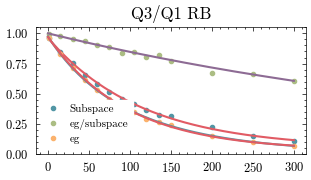

In [19]:
bounds = ([0, 0, 0], [1, np.inf, np.inf])

cut = slice(0, 200)

popt_13, pcov = opt.curve_fit(fit, x_rb_13[cut], popln_subspace_avg_13[cut], sigma=popln_subspace_err_13[cut], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_13 = np.sqrt(np.diag(pcov))

popt2_13, pcov2 = opt.curve_fit(fit, x_rb_13[cut], popln_eg_renorm_13[cut], p0=[0.8, 0.01, 0.01], sigma=popln_eg_renorm_err_13[cut], absolute_sigma=True, maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr2_13 = np.sqrt(np.diag(pcov2))

# Alternative to fitting eg/subspace: fit to double exponential "survival probability"
popt4_13, pcov4 = fitrb_l1_l2(x_rb_13, popln_eg_13, p1=popt_13[0], sigma=popln_eg_err_13)
perr4_13 = np.sqrt(np.diag(pcov4))

# Alternative to fitting eg/subspace: fit to single exponential "survival probability"
popt5_13, pcov5 = opt.curve_fit(fit, x_rb_13, popln_eg_13, sigma=popln_eg_err_13, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr5_13 = np.sqrt(np.diag(pcov5))

x_rb_fit_13 = np.linspace(0, np.max(x_rb_13), 1000)
y_fit_pop_13 = fit(x_rb_fit_13, *popt_13)
y_fit_leak_13 = fit(x_rb_fit_13, *popt2_13)
y_fit_surv_13 = rb_decay_l1_l2(x_rb_fit_13, popt_13[0], *popt4_13)
y_fit_surv_single_13 = fit(x_rb_fit_13, *popt5_13)

plt.figure()
plt.title("Q3/Q1 RB")
plt.plot(x_rb_13, popln_subspace_avg_13, 'o', label='Subspace')
plt.plot(x_rb_fit_13, y_fit_pop_13)
plt.plot(x_rb_13, popln_eg_renorm_13, 'o', label='eg/subspace')
plt.plot(x_rb_fit_13, y_fit_leak_13)
plt.plot(x_rb_13, popln_eg_13, 'o', label='eg')
plt.plot(x_rb_fit_13, y_fit_surv_13)
plt.plot(x_rb_fit_13, y_fit_surv_single_13)
plt.legend()
plt.tight_layout()
plt.ylim(0, 1.05)
# log scale 
plt.show()

### IRB input - output 2

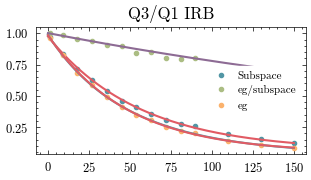

In [20]:
bounds = ([0, 0, 0], [1, np.inf, np.inf])
cut = slice(0, 100)

popt_x_13, pcov = opt.curve_fit(fit, x_rb_x_13, popln_subspace_avg_x_13, sigma=popln_subspace_err_x_13, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_x_13 = np.sqrt(np.diag(pcov))

popt2_x_13, pcov2 = opt.curve_fit(fit, x_rb_x_13[cut], popln_eg_renorm_x_13[cut], p0=[0.8, 0.01, 0.01], sigma=popln_eg_renorm_err_x_13[cut], absolute_sigma=True, maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr2_x_13 = np.sqrt(np.diag(pcov2))

# Alternative to fitting eg/subspace: fit to double exponential "survival probability"
popt4_x_13, pcov4 = fitrb_l1_l2(x_rb_x_13, popln_eg_x_13, p1=popt_x_13[0], sigma=popln_eg_err_x_13)
perr4_x_13 = np.sqrt(np.diag(pcov4))

# Alternative to fitting eg/subspace: fit to single exponential "survival probability"
popt5_x_13, pcov5 = opt.curve_fit(fit, x_rb_x_13, popln_eg_x_13, sigma=popln_eg_err_x_13, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr5_x_13 = np.sqrt(np.diag(pcov5))

x_rb_fit_x_13 = np.linspace(0, np.max(x_rb_x_13), 1000)
y_fit_pop_x_13 = fit(x_rb_fit_x_13, *popt_x_13)
y_fit_leak_x_13 = fit(x_rb_fit_x_13, *popt2_x_13)
y_fit_surv_x_13 = rb_decay_l1_l2(x_rb_fit_x_13, popt_x_13[0], *popt4_x_13)
y_fit_surv_single_x_13 = fit(x_rb_fit_x_13, *popt5_x_13)

plt.figure()
plt.title("Q3/Q1 IRB")
plt.plot(x_rb_x_13, popln_subspace_avg_x_13, 'o', label='Subspace')
plt.plot(x_rb_fit_x_13, y_fit_pop_x_13)
plt.plot(x_rb_x_13, popln_eg_renorm_x_13, 'o', label='eg/subspace')
plt.plot(x_rb_fit_x_13, y_fit_leak_x_13)
plt.plot(x_rb_x_13, popln_eg_x_13, 'o', label='eg')
plt.plot(x_rb_fit_x_13, y_fit_surv_x_13)
plt.plot(x_rb_fit_x_13, y_fit_surv_single_x_13)
plt.legend()
plt.tight_layout()
plt.show()

### RB input - output 1

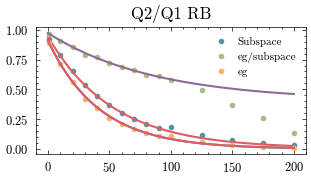

In [21]:
bounds = ([0, 0, 0], [1, np.inf, np.inf])

cut = slice(0, 10)
# cut = slice(0, 100)

popt_12, pcov = opt.curve_fit(fit, x_rb_12[cut], popln_subspace_avg_12[cut], sigma=popln_subspace_err_12[cut], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
# popt_12, pcov = opt.curve_fit(fit, x_rb_12, popln_subspace_avg_12, sigma=popln_subspace_err_12, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_12 = np.sqrt(np.diag(pcov))

popt2_12, pcov2 = opt.curve_fit(fit, x_rb_12[cut], popln_eg_renorm_12[cut], p0=[0.8, 0.01, 0.01], sigma=popln_eg_renorm_err_12[cut], absolute_sigma=True, maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr2_12 = np.sqrt(np.diag(pcov2))

# Alternative to fitting eg/subspace: fit to double exponential "survival probability"
popt4_12, pcov4 = fitrb_l1_l2(x_rb_12, popln_eg_12, p1=popt_12[0], sigma=popln_eg_err_12)
perr4_12 = np.sqrt(np.diag(pcov4))

# Alternative to fitting eg/subspace: fit to single exponential "survival probability"
popt5_12, pcov5 = opt.curve_fit(fit, x_rb_12, popln_eg_12, sigma=popln_eg_err_12, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr5_12 = np.sqrt(np.diag(pcov5))

x_rb_fit_12 = np.linspace(0, np.max(x_rb_12), 1000)
y_fit_pop_12 = fit(x_rb_fit_12, *popt_12)
y_fit_leak_12 = fit(x_rb_fit_12, *popt2_12)
y_fit_surv_12 = rb_decay_l1_l2(x_rb_fit_12, popt_12[0], *popt4_12)
y_fit_surv_single_12 = fit(x_rb_fit_12, *popt5_12)

y_fit_erase_12 = None

plt.figure()
plt.title("Q2/Q1 RB")
plt.plot(x_rb_12, popln_subspace_avg_12, 'o', label='Subspace')
plt.plot(x_rb_fit_12, y_fit_pop_12)
plt.plot(x_rb_12, popln_eg_renorm_12, 'o', label='eg/subspace')
plt.plot(x_rb_fit_12, y_fit_leak_12)
plt.plot(x_rb_12, popln_eg_12, 'o', label='eg')
plt.plot(x_rb_fit_12, y_fit_surv_12)
plt.plot(x_rb_fit_12, y_fit_surv_single_12)
plt.legend()
plt.tight_layout()
plt.show()

### IRB input-output 1

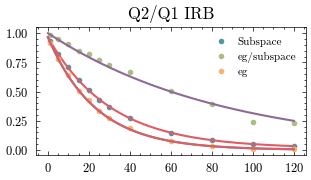

In [22]:
bounds = ([0, 0, 0], [1, np.inf, np.inf])
cut = slice(0, 100)

popt_x_12, pcov = opt.curve_fit(fit, x_rb_x_12, popln_subspace_avg_x_12, sigma=popln_subspace_err_x_12, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_x_12 = np.sqrt(np.diag(pcov))

popt2_x_12, pcov2 = opt.curve_fit(fit, x_rb_x_12[cut], popln_eg_renorm_x_12[cut], p0=[0.8, 0.01, 0.01], sigma=popln_eg_renorm_err_x_12[cut], absolute_sigma=True, maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr2_x_12 = np.sqrt(np.diag(pcov2))

# Alternative to fitting eg/subspace: fit to double exponential "survival probability"
popt4_x_12, pcov4 = fitrb_l1_l2(x_rb_x_12, popln_eg_x_12, p1=popt_x_12[0], sigma=popln_eg_err_x_12)
perr4_x_12 = np.sqrt(np.diag(pcov4))

# Alternative to fitting eg/subspace: fit to single exponential "survival probability"
popt5_x_12, pcov5 = opt.curve_fit(fit, x_rb_x_12, popln_eg_x_12, sigma=popln_eg_err_x_12, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr5_x_12 = np.sqrt(np.diag(pcov5))

x_rb_fit_x_12 = np.linspace(0, np.max(x_rb_x_12), 1000)
y_fit_pop_x_12 = fit(x_rb_fit_x_12, *popt_x_12)
y_fit_leak_x_12 = fit(x_rb_fit_x_12, *popt2_x_12)
y_fit_surv_x_12 = rb_decay_l1_l2(x_rb_fit_x_12, popt_x_12[0], *popt4_x_12)
y_fit_surv_single_x_12 = fit(x_rb_fit_x_12, *popt5_x_12)

plt.figure()
plt.title("Q2/Q1 IRB")
plt.plot(x_rb_x_12, popln_subspace_avg_x_12, 'o', label='Subspace')
plt.plot(x_rb_fit_x_12, y_fit_pop_x_12)
plt.plot(x_rb_x_12, popln_eg_renorm_x_12, 'o', label='eg/subspace')
plt.plot(x_rb_fit_x_12, y_fit_leak_x_12)
plt.plot(x_rb_x_12, popln_eg_x_12, 'o', label='eg')
plt.plot(x_rb_fit_x_12, y_fit_surv_x_12)
plt.plot(x_rb_fit_x_12, y_fit_surv_single_x_12)
plt.legend()
plt.tight_layout()
plt.show()

## Process the fits

In [23]:
avg_X_per_clifford = 2.167 / 2 # got this by counting the average number of X/2's per Clifford gate in the group, divide by 2

In [24]:
def get_errors(
    popt, popt2, popt4, popt5,
    perr, perr2, perr4, perr5,
    popt_x, popt2_x, popt4_x, popt5_x,
    perr_x, perr2_x, perr4_x, perr5_x,
    d=2,
    ):

    lambda1 = popt[0]
    A = popt[2]
    lambda2 = [popt2[0], popt4[3], popt5[0]][2]
    lambda2_err = [perr2[0], perr4[3], perr5[0]][2]
    L = (1 - A)*(1 - lambda1)
    Lerr = L*np.sqrt((perr[2]/(1 - A))**2 + (perr[0]/(1 - lambda1))**2)

    if popt_x is not None:
        lambda1_x = popt_x[0]
        A_x = popt_x[2]
        lambda2_x = [popt2_x[0], popt4_x[3], popt5_x[0]][2]
        lambda2_x_err = [perr2_x[0], perr4_x[3], perr5_x[0]][2]
    
    print('lambda2', lambda2)
    print('lambda1', lambda1)
    if popt_x is not None:
        print('lambda2_x', lambda2_x)
        print('lambda1_x', lambda1_x)
        
    print('err leak free:', (1 - (1/d) * ((d-1)*lambda2 + 1))*100)
    print('err err leak free:', (np.sqrt((d-1)**2 / d**2 * lambda2_err**2))*100)
        
        
    lambda2 = lambda2*lambda1
    print('lambda2', lambda2)
    lambda2_err = lambda2*np.sqrt((lambda2_err/lambda2)**2 + (perr[0]/lambda1)**2)

    err = 1 - (1/d) * ((d-1)*lambda2 + 1 - L) # this is the RB error with a leakage contribution
    err_err = np.sqrt((d-1)**2 / d**2 * lambda2_err**2 + Lerr**2 / d**2)

    if popt_x is None:
        results_dict = dict(
            err=err,
            err_err=err_err,
            L=L,
            Lerr=Lerr,
        ) 
        return results_dict

    lambda2_x = lambda2_x*lambda1_x
    print('lambda2_x', lambda2_x)

    lambda2_x_err = lambda2_x*np.sqrt((lambda2_x_err/lambda2_x)**2 + (perr_x[0]/lambda1_x)**2)
    
    L_int = (1 - A_x)*(1 - lambda1_x)
    Lerr_x = L_int*np.sqrt((perr_x[2]/(1 - A_x))**2 + (perr_x[0]/(1 - lambda1_x))**2)

    err_int = 1 - (1/d) * ((d-1)*lambda2_x + 1 - L_int)
    err_int_err = np.sqrt((d-1)**2 / d**2 * lambda2_x_err**2 + Lerr_x**2 / d**2)

    err_X = 1 - (1 - err_int) / (1 - err)
    err_X_err = np.sqrt((err_int_err**2/(1-err)**2) + (1/(err-1) - (err-err_int)/(1-err)**2)**2 * err_err**2)

    L_tot = 1 - (1 - L_int) / (1 - L)
    L_tot_err = np.sqrt(Lerr_x**2/(1 - L)**2 + Lerr**2*L_int**2/(1 - L)**4)

    err_tot = err_X
    err_tot_err = err_X_err

    F = 1 - err_tot  
    F_err = err_tot_err

    results_dict = dict(
        err=err,
        err_err=err_err,

        err_X=err_X,
        err_X_err=err_X_err,

        err_int=err_int,
        err_int_err=err_int_err,

        L=L,
        Lerr=Lerr,

        L_int=L_int,
        Lerr_x=Lerr_x,

        L_tot=L_tot,
        L_tot_err=L_tot_err,

        F=F,
        F_err=F_err,
    )
    return results_dict

In [25]:
results_12 = get_errors(
    popt_12, popt2_12, popt4_12, popt5_12,
    perr_12, perr2_12, perr4_12, perr5_12,
    popt_x_12, popt2_x_12, popt4_x_12, popt5_x_12,
    perr_x_12, perr2_x_12, perr4_x_12, perr5_x_12,
)

print("All values in percent")
print("Q2/Q1")

print('Error reference per X (total error per clifford): %.3f +/- %.3f' % (results_12['err']*100, results_12['err_err'] *100))
print('Error per X (the total error per X = 1 - F): %.3f +/- %.3f' % (results_12['err_X']*100, results_12['err_X_err'] *100))
print('Leakage error from reference per X: %.3f +/- %.3f' % (results_12['L']*100, results_12['Lerr'] *100))
print('Leakage error from interleaved per X: %.3f +/- %.3f' % (results_12['L_int']*100, results_12['Lerr_x'] *100))
print('Leakage per swap overall: %.3f +/- %.3f' % (results_12['L_tot']*100, results_12['L_tot_err']*100))
print('Fidelity:', 100*results_12['F'], '+/-', results_12['F_err']*100)  

lambda2 0.9762297821161262
lambda1 0.9811743780230824
lambda2_x 0.958338017630132
lambda1_x 0.9678077408575059
err leak free: 1.188510894193695
err err leak free: 0.010755733648624402
lambda2 0.9578516492753993
lambda2_x 0.9274869518204787
All values in percent
Q2/Q1
Error reference per X (total error per clifford): 3.046 +/- 0.045
Error per X (the total error per X = 1 - F): 2.235 +/- 0.054
Leakage error from reference per X: 1.877 +/- 0.065
Leakage error from interleaved per X: 3.174 +/- 0.031
Leakage per swap overall: 1.321 +/- 0.031
Fidelity: 97.76540335758082 +/- 0.05438259520979417


In [26]:
results_13 = get_errors(
    popt_13, popt2_13, popt4_13, popt5_13,
    perr_13, perr2_13, perr4_13, perr5_13,
    popt_x_13, popt2_x_13, popt4_x_13, popt5_x_13,
    perr_x_13, perr2_x_13, perr4_x_13, perr5_x_13,
)

print("All values in percent")
print("Q3/Q1")
print('Error reference (total error per clifford): %.3f +/- %.3f' % (results_13['err']*100, results_13['err_err']*100))
print('Error per X (total error per X = 1-F): %.3f +/- %.3f' % (results_13['err_X']*100, results_13['err_X_err']*100))
print('Leakage error from reference: %.3f +/- %.3f' % (results_13['L']*100, results_13['Lerr']*100))
print('Leakage error from interleaved: %.3f +/- %.3f' % (results_13['L_int']*100, results_13['Lerr_x']*100))
print('Leakage per swap overall: %.3f +/- %.3f' % (results_13['L_tot']*100, results_13['L_tot_err']*100))
print('Fidelity:', 100*results_13['F'], '+/-', results_13['F_err']*100)  

lambda2 0.9896539333591842
lambda1 0.9913175060379622
lambda2_x 0.9796001799735847
lambda1_x 0.9822559036082692
err leak free: 0.517303332040786
err err leak free: 0.008521049760911592
lambda2 0.9810612690582861
lambda2_x 0.9622180599547766
All values in percent
Q3/Q1
Error reference (total error per clifford): 1.360 +/- 0.010
Error per X (total error per X = 1-F): 1.382 +/- 0.020
Leakage error from reference: 0.826 +/- 0.008
Leakage error from interleaved: 1.669 +/- 0.013
Leakage per swap overall: 0.850 +/- 0.013
Fidelity: 98.61764321857255 +/- 0.020019246695917363


## Fig 3c-f

In [27]:
popt_eg_12, pcov = opt.curve_fit(fit, x_rb_12, pop_dict_12['avg']['geg'], sigma=pop_dict_12['err']['geg'], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_eg_12 = np.sqrt(np.diag(pcov))

popt_eg_x_12, pcov = opt.curve_fit(fit, x_rb_x_12, pop_dict_x_12['avg']['geg'], sigma=pop_dict_x_12['err']['geg'], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_eg_x_12 = np.sqrt(np.diag(pcov))

popt_eg_13, pcov = opt.curve_fit(fit, x_rb_13, pop_dict_13['avg']['eeg'], sigma=pop_dict_13['err']['eeg'], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_eg_13 = np.sqrt(np.diag(pcov))

popt_eg_x_13, pcov = opt.curve_fit(fit, x_rb_x_13, pop_dict_x_13['avg']['eeg'], sigma=pop_dict_x_13['err']['geg'], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_eg_x_13 = np.sqrt(np.diag(pcov))



In [28]:
color_eg = '#386641'
color_subspace = '#6a994e'
color_post = '#a7c957'

rb popln geg 12 [0.89281456 0.71000072 0.55926209 0.42043346 0.34341553 0.26245887
 0.20535902 0.16645422 0.13024018 0.106021   0.10349106 0.05598517
 0.02828317 0.01218762 0.0042838 ]
irb popln geg 12 [0.91681574 0.7777137  0.64543607 0.50953068 0.42465979 0.33362326
 0.26956426 0.18567472 0.07511777 0.03222313 0.01158405 0.00827784]


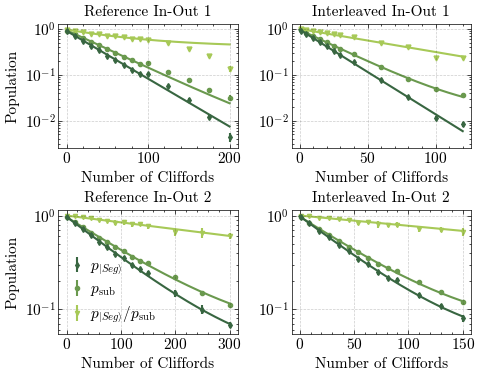

In [29]:
darkmode = False

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use('S:\Connie\prx.mplstyle')
if darkmode: plt.style.use('dark_background')

fig3, ax3 = plt.subplots(2, 2, figsize=(5, 4.0), sharey=False)
plt.subplots_adjust(hspace=0.5) 
plt.subplots_adjust(wspace=0.3) 

labelsize = 11

ax3[0, 0].errorbar(x_rb_12,  pop_dict_12['avg']['geg'], yerr=z*pop_dict_12['err']['geg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
print("rb popln geg 12", pop_dict_12['avg']['geg'])
ax3[0, 0].errorbar(x_rb_12, popln_subspace_avg_12, yerr=z*popln_subspace_err_12, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
ax3[0, 0].errorbar(x_rb_12, popln_eg_renorm_12, yerr=z*popln_eg_renorm_err_12, fmt='v', markersize=3.5, label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post, linestyle='', zorder=0)
ax3[0, 0].plot(x_rb_fit_12, fit(x_rb_fit_12, *popt_eg_12),  color=color_eg)
ax3[0, 0].plot(x_rb_fit_12, y_fit_pop_12, color=color_subspace, zorder=1)
ax3[0, 0].plot(x_rb_fit_12, y_fit_leak_12, color=color_post, zorder=1)
ax3[0, 0].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)


ax3[0, 1].errorbar(x_rb_x_12,  pop_dict_x_12['avg']['geg'], yerr=z*pop_dict_x_12['err']['geg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
ax3[0, 1].errorbar(x_rb_x_12, popln_subspace_avg_x_12, yerr=z*popln_subspace_err_x_12, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
print("irb popln geg 12", pop_dict_x_12['avg']['geg'])
ax3[0, 1].errorbar(x_rb_x_12, popln_eg_renorm_x_12, yerr=z*popln_eg_renorm_err_x_12, fmt='v', markersize=3.5, label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post, linestyle='', zorder=0)
ax3[0, 1].plot(x_rb_fit_x_12, fit(x_rb_fit_x_12, *popt_eg_x_12),  color=color_eg)
ax3[0, 1].plot(x_rb_fit_x_12, y_fit_pop_x_12, color=color_subspace, zorder=1)
ax3[0, 1].plot(x_rb_fit_x_12, y_fit_leak_x_12, color=color_post, zorder=1)
ax3[0, 1].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)

ax3[1, 0].errorbar(x_rb_13,  pop_dict_13['avg']['eeg'], yerr=z*pop_dict_13['err']['eeg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
ax3[1, 0].errorbar(x_rb_13, popln_subspace_avg_13, yerr=z*popln_subspace_err_13, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
ax3[1, 0].errorbar(x_rb_13, popln_eg_renorm_13, yerr=z*popln_eg_renorm_err_13, fmt='v', label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post,
                linestyle='', zorder=0)
ax3[1, 0].plot(x_rb_fit_13, fit(x_rb_fit_13, *popt_eg_13),  color=color_eg)
ax3[1, 0].plot(x_rb_fit_13, y_fit_pop_13, color=color_subspace, zorder=1)
ax3[1, 0].plot(x_rb_fit_13, y_fit_leak_13, color=color_post, zorder=1)
ax3[1, 0].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)

ax3[1, 1].errorbar(x_rb_x_13,  pop_dict_x_13['avg']['eeg'], yerr=z*pop_dict_x_13['err']['eeg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
ax3[1, 1].errorbar(x_rb_x_13, popln_subspace_avg_x_13, yerr=z*popln_subspace_err_x_13, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
ax3[1, 1].errorbar(x_rb_x_13, popln_eg_renorm_x_13, yerr=z*popln_eg_renorm_err_x_13, fmt='v', label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post,
                linestyle='', zorder=0)
ax3[1, 1].plot(x_rb_fit_x_13, fit(x_rb_fit_x_13, *popt_eg_x_13),  color=color_eg)
ax3[1, 1].plot(x_rb_fit_x_13, y_fit_pop_x_13, color=color_subspace, zorder=1)
ax3[1, 1].plot(x_rb_fit_x_13, y_fit_leak_x_13, color=color_post, zorder=1)
ax3[1, 1].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)



scale = 'log'

plt.sca(ax3[0, 0])
plt.grid(color='k', alpha=0.2)
ax3[0, 0].set_yscale(scale)
ax3[0, 0].set_xticks([0, 100, 200])
ax3[0, 0].set_yticks([1, 1e-1, 1e-2])
ax3[0, 0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

plt.sca(ax3[1, 0])
plt.grid(color='k', alpha=0.2)
ax3[1, 0].set_yscale(scale)
ax3[1, 0].set_xticks([0, 100, 200, 300])
ax3[1, 0].set_yticks([1, 1e-1])
ax3[1, 0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

plt.sca(ax3[0, 1])
plt.grid(color='k', alpha=0.2)
ax3[0, 1].set_yscale(scale)
ax3[0, 1].set_xticks([0, 50, 100])
ax3[0, 1].sharey(ax3[0, 0])
ax3[0, 1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

plt.sca(ax3[1, 1])
plt.grid(color='k', alpha=0.2)
ax3[1, 1].set_yscale(scale)
ax3[1, 1].set_xticks([0, 50, 100, 150])
ax3[1, 1].sharey(ax3[1, 0])
ax3[1, 1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

ax3[0, 0].set_title('Reference In-Out 1', fontsize=labelsize)
ax3[1, 0].set_title('Reference In-Out 2', fontsize=labelsize)
ax3[0, 1].set_title('Interleaved In-Out 1', fontsize=labelsize)
ax3[1, 1].set_title('Interleaved In-Out 2', fontsize=labelsize)

ax3[0, 0].set_ylabel('Population', fontsize=labelsize)
ax3[1, 0].set_ylabel('Population', fontsize=labelsize)

ax3[0, 0].set_xlabel('Number of Cliffords', fontsize=labelsize)
ax3[0, 1].set_xlabel('Number of Cliffords', fontsize=labelsize)
ax3[1, 0].set_xlabel('Number of Cliffords', fontsize=labelsize)
ax3[1, 1].set_xlabel('Number of Cliffords', fontsize=labelsize)

ax3[1, 0].legend(fontsize=labelsize, loc='lower left', bbox_to_anchor=(0.0, 0.01), frameon=False, handletextpad=0.2, borderpad=0.01)

plt.show()


# RB for the alternative swap lengths

## Input-output 1 alternative swap

### Data processing

In [30]:
file_name_q1q2_short = '00035_rb_EgGf_qubit21.h5'
filename = file_name_q1q2_short[:5] + '_merged_rb_EgGf_qubit21.npz'
full_filename = os.path.join(save_path_name, filename)
data = np.load(full_filename, allow_pickle=True)

#### Compute the error bars

In [31]:
# reload the data
data = np.load(full_filename)
pop_12_short = data['pop']
xpts = data['xpts']
n= len(np.asarray(xpts)[0])

pop_dict_12_short = {}
pop_dict_12_short['avg'] = {}
pop_dict_12_short['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13 should be < 1
    
    _pop = pop_12_short[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))
        
        
    pop_dict_12_short['avg'][state] = _pop_post_avg
    pop_dict_12_short['err'][state] = _pop_post_err
    
    x_rb_12_short = np.unique(xpts)

#### Define subspaces

In [32]:
# define the subspace population and its error
popln_subspace_avg_12_short=  np.sum([pop_dict_12_short['avg'][state] for state in state_subspace_12], axis=0)
popln_subspace_err_12_short = np.std([pop_dict_12_short['err'][state] for state in state_subspace_12], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_12_short[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_12:
        _pop_temp += pop_12_short[:, :, idx]
popln_subspace_err_12_short = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_12_short = pop_dict_12_short['avg']['geg']
popln_eg_renorm_12_short = popln_eg_12_short/popln_subspace_avg_12_short

idx_eg = state_name_str.index('geg')
_pop_temp = pop_12_short[:, :, idx_eg]
popln_eg_err_12_short = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('geg')
idx_gf = state_name_str.index('ggf')
_pop_temp = pop_12_short[:, :, idx_eg]/(pop_12_short[:, :, idx_eg] + pop_12_short[:, :, idx_gf])
popln_eg_renorm_err_12_short = np.std(_pop_temp, axis=1)/np.sqrt(n)



popln_not_erase_12_short = 1 - np.sum([pop_dict_12_short['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_12_short[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_12_short[:, :, idx]
popln_not_erase_err_12_short = np.std(_pop_temp, axis=1)/np.sqrt(n)

### Fit

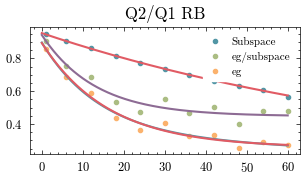

In [33]:
bounds = ([0, 0, 0], [1, np.inf, np.inf])

cut = slice(0, 10)

popt_12_short, pcov = opt.curve_fit(fit, x_rb_12_short[cut], popln_subspace_avg_12_short[cut], sigma=popln_subspace_err_12_short[cut], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_12_short = np.sqrt(np.diag(pcov))

popt2_12_short, pcov2 = opt.curve_fit(fit, x_rb_12_short[cut], popln_eg_renorm_12_short[cut], p0=[0.8, 0.01, 0.01], sigma=popln_eg_renorm_err_12_short[cut], absolute_sigma=True, maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr2_12_short = np.sqrt(np.diag(pcov2))

# Alternative to fitting eg/subspace: fit to double exponential "survival probability"
popt4_12_short, pcov4 = fitrb_l1_l2(x_rb_12_short, popln_eg_12_short, p1=popt_12_short[0], sigma=popln_eg_err_12_short)
perr4_12_short = np.sqrt(np.diag(pcov4))

# Alternative to fitting eg/subspace: fit to single exponential "survival probability"
popt5_12_short, pcov5 = opt.curve_fit(fit, x_rb_12_short, popln_eg_12_short, sigma=popln_eg_err_12_short, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr5_12_short = np.sqrt(np.diag(pcov5))

x_rb_fit_12_short = np.linspace(0, np.max(x_rb_12_short), 1000)
y_fit_pop_12_short = fit(x_rb_fit_12_short, *popt_12_short)
y_fit_leak_12_short = fit(x_rb_fit_12_short, *popt2_12_short)
y_fit_surv_12_short = rb_decay_l1_l2(x_rb_fit_12_short, popt_12_short[0], *popt4_12_short)
y_fit_surv_single_12_short = fit(x_rb_fit_12_short, *popt5_12_short)

plt.figure()
plt.title("Q2/Q1 RB")
plt.plot(x_rb_12_short, popln_subspace_avg_12_short, 'o', label='Subspace')
plt.plot(x_rb_fit_12_short, y_fit_pop_12_short)
plt.plot(x_rb_12_short, popln_eg_renorm_12_short, 'o', label='eg/subspace')
plt.plot(x_rb_fit_12_short, y_fit_leak_12_short)
plt.plot(x_rb_12_short, popln_eg_12_short, 'o', label='eg')
plt.plot(x_rb_fit_12_short, y_fit_surv_12_short)
plt.plot(x_rb_fit_12_short, y_fit_surv_single_12_short)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
results_12_short = get_errors(
    popt_12_short, popt2_12_short, popt4_12_short, popt5_12_short,
    perr_12_short, perr2_12_short, perr4_12_short, perr5_12_short,
    None, None, None, None, None, None, None, None,
)

print("All values in percent")
print("Q2/Q1")
print('Error reference per X (total error per clifford): %.3f +/- %.3f' % (results_12_short['err']*100, results_12_short['err_err'] *100))
print('Leakage error from reference per X: %.3f +/- %.3f' % (results_12_short['L']*100, results_12_short['Lerr'] *100))

lambda2 0.9408594885025582
lambda1 0.9901299965697148
err leak free: 2.9570255748720964
err err leak free: 0.454447238043951
lambda2 0.9315732021236215
All values in percent
Q2/Q1
Error reference per X (total error per clifford): 3.862 +/- 0.475
Leakage error from reference per X: 0.882 +/- 0.213


## Input-output 2 alternative swap

In [35]:
file_name_q1q3_long = '00007_rb_EgGf_qubit31.h5'
file_name_q1q3_long_bis = '00008_rb_EgGf_qubit31.h5'

data_file_13_long = os.path.join(save_path_name, file_name_q1q3_long[:5] + '_' + file_name_q1q3_long_bis[:5] + '_merged_rb_EgGf_qubit31.npz')

data_13_long= np.load(data_file_13_long, allow_pickle=True)

### Data processing

#### Compute the error bar

In [36]:
# reload the data
pop_13_long = data_13_long['pop']
xpts = data_13_long['xpts']
n = len(np.asarray(xpts)[0])

pop_dict_13_long = {}
pop_dict_13_long['avg'] = {}
pop_dict_13_long['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13_long should be < 1
    
    _pop = pop_13_long[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))
    pop_dict_13_long['avg'][state] = _pop_post_avg
    pop_dict_13_long['err'][state] = _pop_post_err
    x_rb_13_long = np.unique(xpts)

#### Define subspaces

In [37]:
# define the subspace population and its error
popln_subspace_avg_13_long=  np.sum([pop_dict_13_long['avg'][state] for state in state_subspace_13], axis=0)
popln_subspace_err_13_long = np.std([pop_dict_13_long['err'][state] for state in state_subspace_13], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_13_long[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_13:
        _pop_temp += pop_13_long[:, :, idx]
popln_subspace_err_13_long = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_13_long = pop_dict_13_long['avg']['eeg']
popln_eg_renorm_13_long = popln_eg_13_long/popln_subspace_avg_13_long

idx_eg = state_name_str.index('eeg')
_pop_temp = pop_13_long[:, :, idx_eg]
popln_eg_err_13_long = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('eeg')
idx_gf = state_name_str.index('egf')
_pop_temp = pop_13_long[:, :, idx_eg]/(pop_13_long[:, :, idx_eg] + pop_13_long[:, :, idx_gf])
popln_eg_renorm_err_13_long = np.std(_pop_temp, axis=1)/np.sqrt(n)



popln_not_erase_13_long = 1 - np.sum([pop_dict_13_long['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_13_long[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_13_long[:, :, idx]
popln_not_erase_err_13_long = np.std(_pop_temp, axis=1)/np.sqrt(n)

### Fit

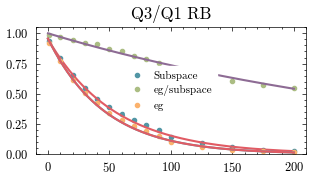

In [38]:
bounds = ([0, 0, 0], [1, np.inf, np.inf])

cut = slice(0, 200)

popt_13_long, pcov = opt.curve_fit(fit, x_rb_13_long[cut], popln_subspace_avg_13_long[cut], sigma=popln_subspace_err_13_long[cut], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_13_long = np.sqrt(np.diag(pcov))

popt2_13_long, pcov2 = opt.curve_fit(fit, x_rb_13_long[cut], popln_eg_renorm_13_long[cut], p0=[0.8, 0.01, 0.01], sigma=popln_eg_renorm_err_13_long[cut], absolute_sigma=True, maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr2_13_long = np.sqrt(np.diag(pcov2))

# Alternative to fitting eg/subspace: fit to double exponential "survival probability"
popt4_13_long, pcov4 = fitrb_l1_l2(x_rb_13_long, popln_eg_13_long, p1=popt_13_long[0], sigma=popln_eg_err_13_long)
perr4_13_long = np.sqrt(np.diag(pcov4))

# Alternative to fitting eg/subspace: fit to single exponential "survival probability"
popt5_13_long, pcov5 = opt.curve_fit(fit, x_rb_13_long, popln_eg_13_long, sigma=popln_eg_err_13_long, absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr5_13_long = np.sqrt(np.diag(pcov5))

x_rb_fit_13_long = np.linspace(0, np.max(x_rb_13_long), 1000)
y_fit_pop_13_long = fit(x_rb_fit_13_long, *popt_13_long)
y_fit_leak_13_long = fit(x_rb_fit_13_long, *popt2_13_long)
y_fit_surv_13_long = rb_decay_l1_l2(x_rb_fit_13_long, popt_13_long[0], *popt4_13_long)
y_fit_surv_single_13_long = fit(x_rb_fit_13_long, *popt5_13_long)

plt.figure()
plt.title("Q3/Q1 RB")
plt.plot(x_rb_13_long, popln_subspace_avg_13_long, 'o', label='Subspace')
plt.plot(x_rb_fit_13_long, y_fit_pop_13_long)
plt.plot(x_rb_13_long, popln_eg_renorm_13_long, 'o', label='eg/subspace')
plt.plot(x_rb_fit_13_long, y_fit_leak_13_long)
plt.plot(x_rb_13_long, popln_eg_13_long, 'o', label='eg')
plt.plot(x_rb_fit_13_long, y_fit_surv_13_long)
plt.plot(x_rb_fit_13_long, y_fit_surv_single_13_long)
plt.legend()
plt.tight_layout()
plt.ylim(0, 1.05)
# log scale 
plt.show()

In [39]:
results_13_long = get_errors(
    popt_13_long, popt2_13_long, popt4_13_long, popt5_13_long,
    perr_13_long, perr2_13_long, perr4_13_long, perr5_13_long,
    None, None, None, None, None, None, None, None,
)

print("All values in percent")
print("Q3/Q1")
print('Error reference (total error per clifford): %.3f +/- %.3f' % (results_13_long['err']*100, results_13_long['err_err']*100))
print('Leakage error from reference: %.3f +/- %.3f' % (results_13_long['L']*100, results_13_long['Lerr']*100))

lambda2 0.9786282118015444
lambda1 0.9818129510175572
err leak free: 1.0685894099227822
err err leak free: 0.0074116728662778466
lambda2 0.9608298525779092
All values in percent
Q3/Q1
Error reference (total error per clifford): 2.868 +/- 0.013
Leakage error from reference: 1.819 +/- 0.015


## Fig A4 a-d

In [40]:
popt_eg_12_short, pcov = opt.curve_fit(fit, x_rb_12_short, pop_dict_12_short['avg']['geg'], sigma=pop_dict_12_short['err']['geg'], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_eg_12_short = np.sqrt(np.diag(pcov))

popt_eg_13_long, pcov = opt.curve_fit(fit, x_rb_13_long, pop_dict_13_long['avg']['eeg'], sigma=pop_dict_13_long['err']['eeg'], absolute_sigma=True, p0=[0.99, 0.01, 0.01], maxfev=10000, xtol=1e-15, ftol=1e-15, bounds=bounds)
perr_eg_13_long = np.sqrt(np.diag(pcov))

In [41]:
color_eg = '#386641'
color_subspace = '#6a994e'
color_post = '#a7c957'


rb popln geg 12_short [0.85673017 0.68397501 0.59062293 0.43652476 0.36529919 0.40850999
 0.32573888 0.33307482 0.25210242 0.29063996 0.27149382]
irb popln geg 12 [0.89281456 0.71000072 0.55926209 0.42043346 0.34341553 0.26245887
 0.20535902 0.16645422 0.13024018 0.106021   0.10349106 0.05598517
 0.02828317 0.01218762 0.0042838 ]


C:\Users\slab\AppData\Local\Temp\ipykernel_29208\2107025188.py:72: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax3[1, 0].sharey(ax3[1, 1])


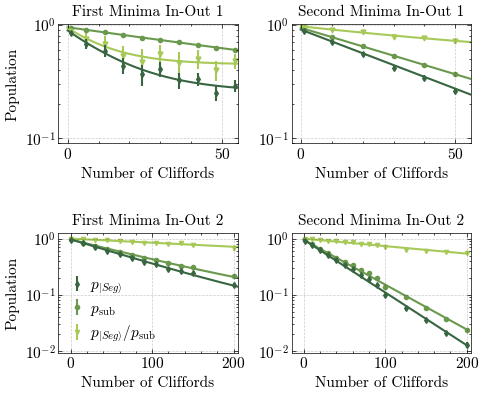

In [42]:
fig3, ax3 = plt.subplots(2, 2, figsize=(5, 4.25), sharey=False)
plt.subplots_adjust(hspace=0.75) 
plt.subplots_adjust(wspace=0.3) 

labelsize = 11

ax3[0, 0].errorbar(x_rb_12_short,  pop_dict_12_short['avg']['geg'], yerr=z*pop_dict_12_short['err']['geg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
print("rb popln geg 12_short", pop_dict_12_short['avg']['geg'])
ax3[0, 0].errorbar(x_rb_12_short, popln_subspace_avg_12_short, yerr=z*popln_subspace_err_12_short, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
ax3[0, 0].errorbar(x_rb_12_short, popln_eg_renorm_12_short, yerr=z*popln_eg_renorm_err_12_short, fmt='v', markersize=3.5, label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post, linestyle='', zorder=0)
ax3[0, 0].plot(x_rb_fit_12_short, fit(x_rb_fit_12_short, *popt_eg_12_short),  color=color_eg)
ax3[0, 0].plot(x_rb_fit_12_short, y_fit_pop_12_short, color=color_subspace, zorder=1)
ax3[0, 0].plot(x_rb_fit_12_short, y_fit_leak_12_short, color=color_post, zorder=1)
ax3[0, 0].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)


ax3[0, 1].errorbar(x_rb_12,  pop_dict_12['avg']['geg'], yerr=z*pop_dict_12['err']['geg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
ax3[0, 1].errorbar(x_rb_12, popln_subspace_avg_12, yerr=z*popln_subspace_err_12, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
print("irb popln geg 12", pop_dict_12['avg']['geg'])
ax3[0, 1].errorbar(x_rb_12, popln_eg_renorm_12, yerr=z*popln_eg_renorm_err_12, fmt='v', markersize=3.5, label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post, linestyle='', zorder=0)
ax3[0, 1].plot(x_rb_fit_12, fit(x_rb_fit_12, *popt_eg_12),  color=color_eg)
ax3[0, 1].plot(x_rb_fit_12, y_fit_pop_12, color=color_subspace, zorder=1)
ax3[0, 1].plot(x_rb_fit_12, y_fit_leak_12, color=color_post, zorder=1)
ax3[0, 1].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)

ax3[1, 0].errorbar(x_rb_13,  pop_dict_13['avg']['eeg'], yerr=z*pop_dict_13['err']['eeg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
ax3[1, 0].errorbar(x_rb_13, popln_subspace_avg_13, yerr=z*popln_subspace_err_13, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
ax3[1, 0].errorbar(x_rb_13, popln_eg_renorm_13, yerr=z*popln_eg_renorm_err_13, fmt='v', label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post,
                linestyle='', zorder=0)
ax3[1, 0].plot(x_rb_fit_13, fit(x_rb_fit_13, *popt_eg_13),  color=color_eg)
ax3[1, 0].plot(x_rb_fit_13, y_fit_pop_13, color=color_subspace, zorder=1)
ax3[1, 0].plot(x_rb_fit_13, y_fit_leak_13, color=color_post, zorder=1)
ax3[1, 0].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)

ax3[1, 1].errorbar(x_rb_13_long,  pop_dict_13_long['avg']['eeg'], yerr=z*pop_dict_13_long['err']['eeg'], fmt='d', label=r'$p_{\left|Seg\right>}$', color=color_eg)
ax3[1, 1].errorbar(x_rb_13_long, popln_subspace_avg_13_long, yerr=z*popln_subspace_err_13_long, fmt='o', label=r'$p_\mathrm{sub}$', color=color_subspace,
                linestyle='', zorder=0)
ax3[1, 1].errorbar(x_rb_13_long, popln_eg_renorm_13_long, yerr=z*popln_eg_renorm_err_13_long, fmt='v', label=r'$p_{\left|Seg\right>}/p_\mathrm{sub}$', color=color_post,
                linestyle='', zorder=0)
ax3[1, 1].plot(x_rb_fit_13_long, fit(x_rb_fit_13_long, *popt_eg_13_long),  color=color_eg)
ax3[1, 1].plot(x_rb_fit_13_long, y_fit_pop_13_long, color=color_subspace, zorder=1)
ax3[1, 1].plot(x_rb_fit_13_long, y_fit_leak_13_long, color=color_post, zorder=1)
ax3[1, 1].tick_params(axis="both", which="major", labelbottom=True, labelleft=True, pad=2)

scale = 'log'

plt.sca(ax3[0, 0])
plt.grid(color='k', alpha=0.2)
ax3[0, 0].set_yscale(scale)
ax3[0, 0].set_xticks([0, 50])
ax3[0, 0].set_xlim(None, 55)
ax3[0, 0].set_yticks([1, 1e-1])
ax3[0, 0].set_ylim(9e-2, None)
ax3[0, 0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

plt.sca(ax3[0, 1])
plt.grid(color='k', alpha=0.2)
ax3[0, 1].set_yscale(scale)
ax3[0, 1].sharex(ax3[0, 0])
ax3[0, 1].sharey(ax3[0, 0])
ax3[0, 1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

plt.sca(ax3[1, 0])
plt.grid(color='k', alpha=0.2)
ax3[1, 0].set_yscale(scale)
ax3[1, 0].set_yticks([1, 1e-1])
ax3[1, 0].set_xticks([0, 100, 200])
ax3[1, 0].set_xlim(None, 205)
ax3[1, 0].sharey(ax3[1, 1])
ax3[1, 0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

plt.sca(ax3[1, 1])
plt.grid(color='k', alpha=0.2)
ax3[1, 1].set_yscale(scale)
ax3[1, 1].sharex(ax3[1, 0])
ax3[1, 1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

ax3[0, 0].set_title('First Minima In-Out 1', fontsize=labelsize)
ax3[1, 0].set_title('First Minima In-Out 2', fontsize=labelsize)
ax3[0, 1].set_title('Second Minima In-Out 1', fontsize=labelsize)
ax3[1, 1].set_title('Second Minima In-Out 2', fontsize=labelsize)

ax3[0, 0].set_ylabel('Population', fontsize=labelsize)
ax3[1, 0].set_ylabel('Population', fontsize=labelsize)

ax3[0, 0].set_xlabel('Number of Cliffords', fontsize=labelsize)
ax3[0, 1].set_xlabel('Number of Cliffords', fontsize=labelsize)
ax3[1, 0].set_xlabel('Number of Cliffords', fontsize=labelsize)
ax3[1, 1].set_xlabel('Number of Cliffords', fontsize=labelsize)

ax3[1, 0].legend(fontsize=labelsize, loc='lower left', bbox_to_anchor=(0.0, 0.01), frameon=False, handletextpad=0.2, borderpad=0.01)

plt.show()